У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('customer_segmentation_train.csv')

print(df.shape)
print("===Пропущені значення===")
print(df.isnull().sum())
print("===Таргет:")
print(df['Segmentation'].value_counts())

(8068, 11)
===Пропущені значення===
ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64
===Таргет:
Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64


In [3]:
df_processed = df.copy()
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

      
categorical_cols = df_processed.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols[categorical_cols != 'Segmentation']

for col in categorical_cols:
    if df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

target_encoder = LabelEncoder()
df_processed['Segmentation'] = target_encoder.fit_transform(df_processed['Segmentation'])

X = df_processed.drop('Segmentation', axis=1)
y = df_processed['Segmentation']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")



Train: (6454, 10), Test: (1614, 10)


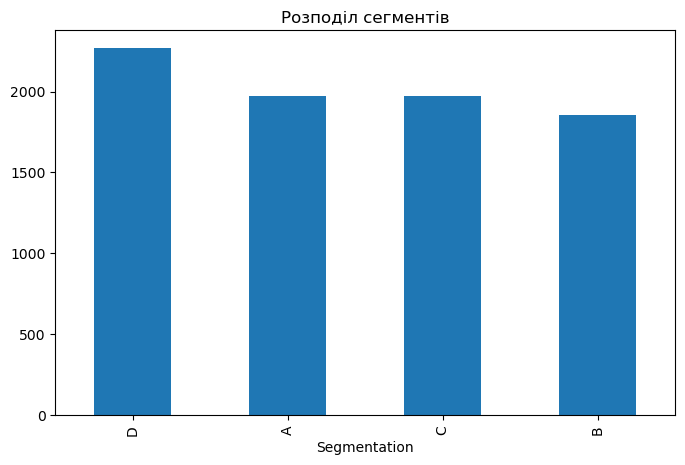

In [4]:
plt.figure(figsize=(8, 5))
df['Segmentation'].value_counts().plot(kind='bar')
plt.title('Розподіл сегментів')
plt.show()

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [5]:
# pip install scikit-learn==1.3.2 imbalanced-learn==0.12.2

['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Segmentation']
Категоріальні колонки: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
Індекси категоріальних колонок: [1, 2, 4, 5, 7, 9]

Оригінальний розподіл класів:
Counter({3: 1814, 0: 1578, 2: 1576, 1: 1486})

=== ВАРІАНТ 1: Базовий SMOTE ===
Некaтегоріальні колонки: ['ID', 'Age', 'Work_Experience', 'Family_Size']
Після базового SMOTE: Counter({0: 1814, 1: 1814, 2: 1814, 3: 1814})
Розмір: (7256, 4)

=== ВАРІАНТ 2: SMOTENC ===
Після SMOTENC: Counter({0: 1814, 1: 1814, 2: 1814, 3: 1814})
Розмір: (7256, 10)

=== SMOTE-Tomek з SMOTENC ===
Після SMOTE-Tomek: Counter({2: 1402, 3: 1395, 1: 1286, 0: 1259})
Розмір: (5342, 10)

=== ПОРІВНЯННЯ ===
Оригінальні дані: 6454 зразків
Базовий SMOTE: 7256 зразків
SMOTENC: 7256 зразків
SMOTE-Tomek: 5342 зразків


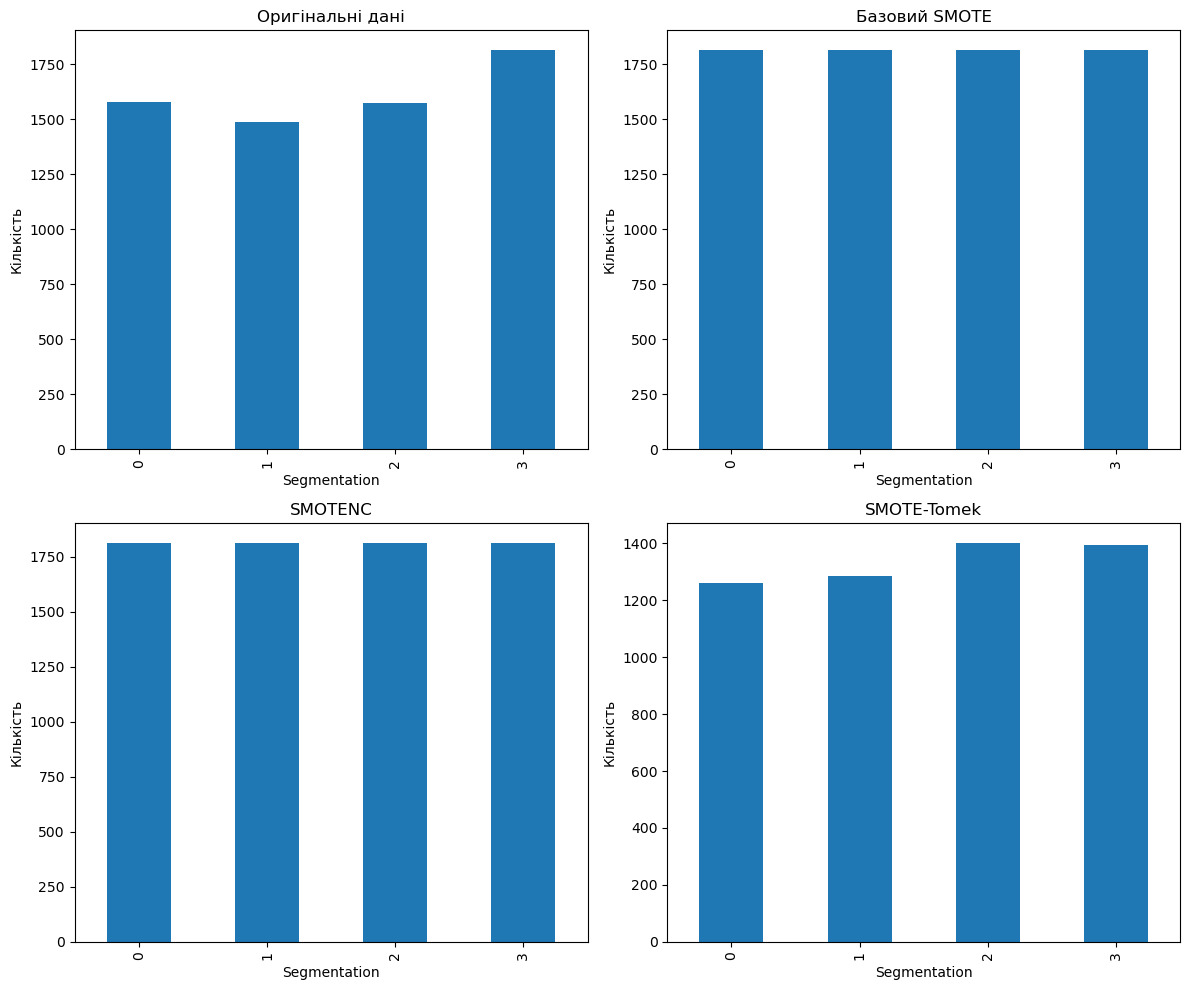


Готово! Створено 2 основних тренувальних набори:
- X_train_smotenc, y_train_smotenc (рекомендований)
- X_train_smotetomek, y_train_smotetomek


In [6]:
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek
from collections import Counter

print(list(df.columns))

original_categorical = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

categorical_indices = []
for i, col in enumerate(X_train.columns):
    if col in original_categorical:
        categorical_indices.append(i)

print(f"Категоріальні колонки: {[X_train.columns[i] for i in categorical_indices]}")
print(f"Індекси категоріальних колонок: {categorical_indices}")

print(f"\nОригінальний розподіл класів:")
print(Counter(y_train))

print("\n=== ВАРІАНТ 1: Базовий SMOTE ===")

non_categorical_indices = [i for i in range(len(X_train.columns)) if i not in categorical_indices]
X_train_numeric = X_train.iloc[:, non_categorical_indices]

print(f"Некaтегоріальні колонки: {list(X_train_numeric.columns)}")

smote_basic = SMOTE(random_state=42)
X_train_smote_basic, y_train_smote_basic = smote_basic.fit_resample(X_train_numeric, y_train)

print(f"Після базового SMOTE: {Counter(y_train_smote_basic)}")
print(f"Розмір: {X_train_smote_basic.shape}")

print("\n=== ВАРІАНТ 2: SMOTENC ===")

smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

print(f"Після SMOTENC: {Counter(y_train_smotenc)}")
print(f"Розмір: {X_train_smotenc.shape}")


print("\n=== SMOTE-Tomek з SMOTENC ===")

smotetomek = SMOTETomek(
    smote=SMOTENC(categorical_features=categorical_indices, random_state=42),
    random_state=42
)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train, y_train)

print(f"Після SMOTE-Tomek: {Counter(y_train_smotetomek)}")
print(f"Розмір: {X_train_smotetomek.shape}")

print("\n=== ПОРІВНЯННЯ ===")
print(f"Оригінальні дані: {X_train.shape[0]} зразків")
print(f"Базовий SMOTE: {X_train_smote_basic.shape[0]} зразків")
print(f"SMOTENC: {X_train_smotenc.shape[0]} зразків") 
print(f"SMOTE-Tomek: {X_train_smotetomek.shape[0]} зразків")


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

pd.Series(y_train).value_counts().sort_index().plot(kind='bar', ax=axes[0,0], title='Оригінальні дані')
axes[0,0].set_ylabel('Кількість')

pd.Series(y_train_smote_basic).value_counts().sort_index().plot(kind='bar', ax=axes[0,1], title='Базовий SMOTE')
axes[0,1].set_ylabel('Кількість')

pd.Series(y_train_smotenc).value_counts().sort_index().plot(kind='bar', ax=axes[1,0], title='SMOTENC')
axes[1,0].set_ylabel('Кількість')

pd.Series(y_train_smotetomek).value_counts().sort_index().plot(kind='bar', ax=axes[1,1], title='SMOTE-Tomek')
axes[1,1].set_ylabel('Кількість')

plt.tight_layout()
plt.show()

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_smotenc_scaled = scaler.fit_transform(X_train_smotenc)
X_train_smotetomek_scaled = scaler.fit_transform(X_train_smotetomek)

In [9]:
print("=== НАВЧАННЯ МОДЕЛЕЙ ONE-VS-REST ===")

# Модель на оригінальних даних
print("Оригінальні дані:")
ovr_original = OneVsRestClassifier(
    LogisticRegression(random_state=42, max_iter=1000),
    n_jobs=-1
)
ovr_original.fit(X_train_scaled, y_train)
y_pred_original = ovr_original.predict(X_test_scaled)

print("Classification Report - Оригінальні дані:")
print(classification_report(y_test, y_pred_original))

=== НАВЧАННЯ МОДЕЛЕЙ ONE-VS-REST ===
Оригінальні дані:
Classification Report - Оригінальні дані:
              precision    recall  f1-score   support

           0       0.40      0.39      0.40       394
           1       0.42      0.08      0.14       372
           2       0.47      0.64      0.54       394
           3       0.59      0.80      0.68       454

    accuracy                           0.50      1614
   macro avg       0.47      0.48      0.44      1614
weighted avg       0.47      0.50      0.45      1614



In [10]:
# Модель на даних після SMOTENC
print("SMOTENC дані:")
ovr_smotenc = OneVsRestClassifier(
    LogisticRegression(random_state=42, max_iter=1000),
    n_jobs=-1
)
ovr_smotenc.fit(X_train_smotenc_scaled, y_train_smotenc)
y_pred_smotenc = ovr_smotenc.predict(X_test_scaled)

print("Classification Report - SMOTENC:")
print(classification_report(y_test, y_pred_smotenc))

SMOTENC дані:
Classification Report - SMOTENC:
              precision    recall  f1-score   support

           0       0.41      0.41      0.41       394
           1       0.38      0.15      0.21       372
           2       0.47      0.63      0.54       394
           3       0.63      0.77      0.69       454

    accuracy                           0.50      1614
   macro avg       0.47      0.49      0.46      1614
weighted avg       0.48      0.50      0.48      1614



In [11]:
# Модель на даних після SMOTE-Tomek
print("SMOTE-Tomek дані:")
ovr_smotetomek = OneVsRestClassifier(
    LogisticRegression(random_state=42, max_iter=1000),
    n_jobs=-1
)
ovr_smotetomek.fit(X_train_smotetomek_scaled, y_train_smotetomek)
y_pred_smotetomek = ovr_smotetomek.predict(X_test_scaled)

print("Classification Report - SMOTE-Tomek:")
print(classification_report(y_test, y_pred_smotetomek))

SMOTE-Tomek дані:
Classification Report - SMOTE-Tomek:
              precision    recall  f1-score   support

           0       0.42      0.36      0.39       394
           1       0.35      0.15      0.20       372
           2       0.46      0.65      0.54       394
           3       0.62      0.78      0.69       454

    accuracy                           0.50      1614
   macro avg       0.46      0.48      0.46      1614
weighted avg       0.47      0.50      0.47      1614



In [12]:
from sklearn.metrics import f1_score
print("\n=== ПОРІВНЯННЯ МОДЕЛЕЙ ===")

# Accuracy
acc_original = accuracy_score(y_test, y_pred_original)
acc_smotenc = accuracy_score(y_test, y_pred_smotenc)
acc_smotetomek = accuracy_score(y_test, y_pred_smotetomek)

print(f"Accuracy:")
print(f"Оригінальні: {acc_original:.4f}")
print(f"SMOTENC: {acc_smotenc:.4f}")
print(f"SMOTE-Tomek: {acc_smotetomek:.4f}")

# Macro F1-score 
f1_original = f1_score(y_test, y_pred_original, average='macro')
f1_smotenc = f1_score(y_test, y_pred_smotenc, average='macro')
f1_smotetomek = f1_score(y_test, y_pred_smotetomek, average='macro')

print(f"\nMacro F1-score:")
print(f"Оригінальні: {f1_original:.4f}")
print(f"SMOTENC: {f1_smotenc:.4f}")
print(f"SMOTE-Tomek: {f1_smotetomek:.4f}")

f1_weighted_original = f1_score(y_test, y_pred_original, average='weighted')
f1_weighted_smotenc = f1_score(y_test, y_pred_smotenc, average='weighted')
f1_weighted_smotetomek = f1_score(y_test, y_pred_smotetomek, average='weighted')

print(f"\nWeighted F1-score:")
print(f"Оригінальні: {f1_weighted_original:.4f}")
print(f"SMOTENC: {f1_weighted_smotenc:.4f}")
print(f"SMOTE-Tomek: {f1_weighted_smotetomek:.4f}")


=== ПОРІВНЯННЯ МОДЕЛЕЙ ===
Accuracy:
Оригінальні: 0.4963
SMOTENC: 0.5031
SMOTE-Tomek: 0.4988

Macro F1-score:
Оригінальні: 0.4383
SMOTENC: 0.4634
SMOTE-Tomek: 0.4561

Weighted F1-score:
Оригінальні: 0.4513
SMOTENC: 0.4753
SMOTE-Tomek: 0.4682


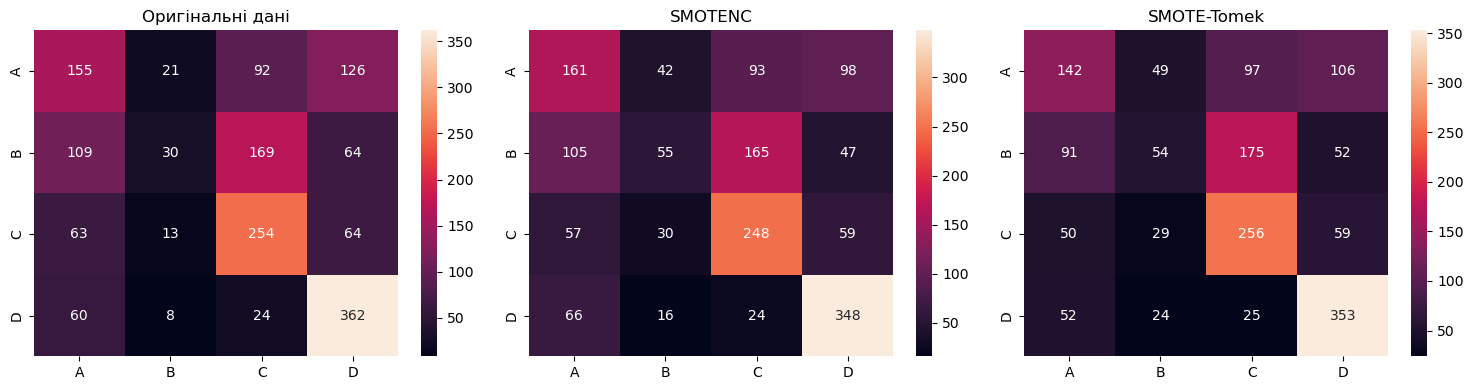

In [13]:
# Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

class_names = target_encoder.classes_

cm1 = confusion_matrix(y_test, y_pred_original)
sns.heatmap(cm1, annot=True, fmt='d', ax=axes[0], 
           xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Оригінальні дані')

cm2 = confusion_matrix(y_test, y_pred_smotenc)
sns.heatmap(cm2, annot=True, fmt='d', ax=axes[1],
           xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('SMOTENC')

cm3 = confusion_matrix(y_test, y_pred_smotetomek)
sns.heatmap(cm3, annot=True, fmt='d', ax=axes[2],
           xticklabels=class_names, yticklabels=class_names)
axes[2].set_title('SMOTE-Tomek')

plt.tight_layout()
plt.show()

### ВИСНОВКИ 
1. Обрана метрика: Macro F1-score  
   Причина: найкраща для багатокласових задач з дисбалансом класів,
   оскільки враховує всі класи рівноцінно незалежно від їх розміру

2. Найкраща модель: SMOTENC (Macro F1-score: 0.4634)

3. Різниця між найкращою та найгіршою моделлю: 0.0251

Суттєва різниця між моделями (0.0251) свідчить про:  
- Вплив збалансування даних на якість моделі  
- Важливість правильної обробки дисбалансу класів  